In [11]:
%matplotlib inline


# Comparison of Calibration of Classifiers

Well calibrated classifiers are probabilistic classifiers for which the output
of :term:`predict_proba` can be directly interpreted as a confidence level.
For instance, a well calibrated (binary) classifier should classify the samples
such that for the samples to which it gave a :term:`predict_proba` value close
to 0.8, approximately 80% actually belong to the positive class.

In this example we will compare the calibration of four different
models: `Logistic_regression`, `gaussian_naive_bayes`,
`Random Forest Classifier <forest>` and `Linear SVM
<svm_classification>`.


Author: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
License: BSD 3 clause.

## Dataset

We will use a synthetic binary classification dataset with 100,000 samples
and 20 features. Of the 20 features, only 2 are informative, 2 are
redundant (random combinations of the informative features) and the
remaining 16 are uninformative (random numbers). Of the 100,000 samples,
100 will be used for model fitting and the remaining for testing.



In [12]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=100_000, n_features=20, n_informative=2, n_redundant=2, random_state=42
)

train_samples = 100  # Samples used for training the models
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=100_000 - train_samples,
)

## Calibration curves

Below, we train each of the four models with the small training dataset, then
plot calibration curves (also known as reliability diagrams) using
predicted probabilities of the test dataset. Calibration curves are created
by binning predicted probabilities, then plotting the mean predicted
probability in each bin against the observed frequency ('fraction of
positives'). Below the calibration curve, we plot a histogram showing
the distribution of the predicted probabilities or more specifically,
the number of samples in each predicted probability bin.



In [13]:
import numpy as np

from sklearn.svm import LinearSVC


class NaivelyCalibratedLinearSVC(LinearSVC):
    """LinearSVC with `predict_proba` method that naively scales
    `decision_function` output."""

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        """Min-max scale output of `decision_function` to [0,1]."""
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba

In [14]:
from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
svc = NaivelyCalibratedLinearSVC(C=1.0)
rfc = RandomForestClassifier()

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (svc, "SVC"),
    (rfc, "Random forest"),
]

C:\Users\RACHIT\AppData\Local\Temp\ipykernel_18740\1285660794.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("Dark2")
C:\Users\RACHIT\anaconda3\lib\site-packages\sklearn\calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
C:\Users\RACHIT\anaconda3\lib\site-packages\sklearn\calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
C:\Users\RACHIT\anaconda3\lib\site-packages\sklearn\cal

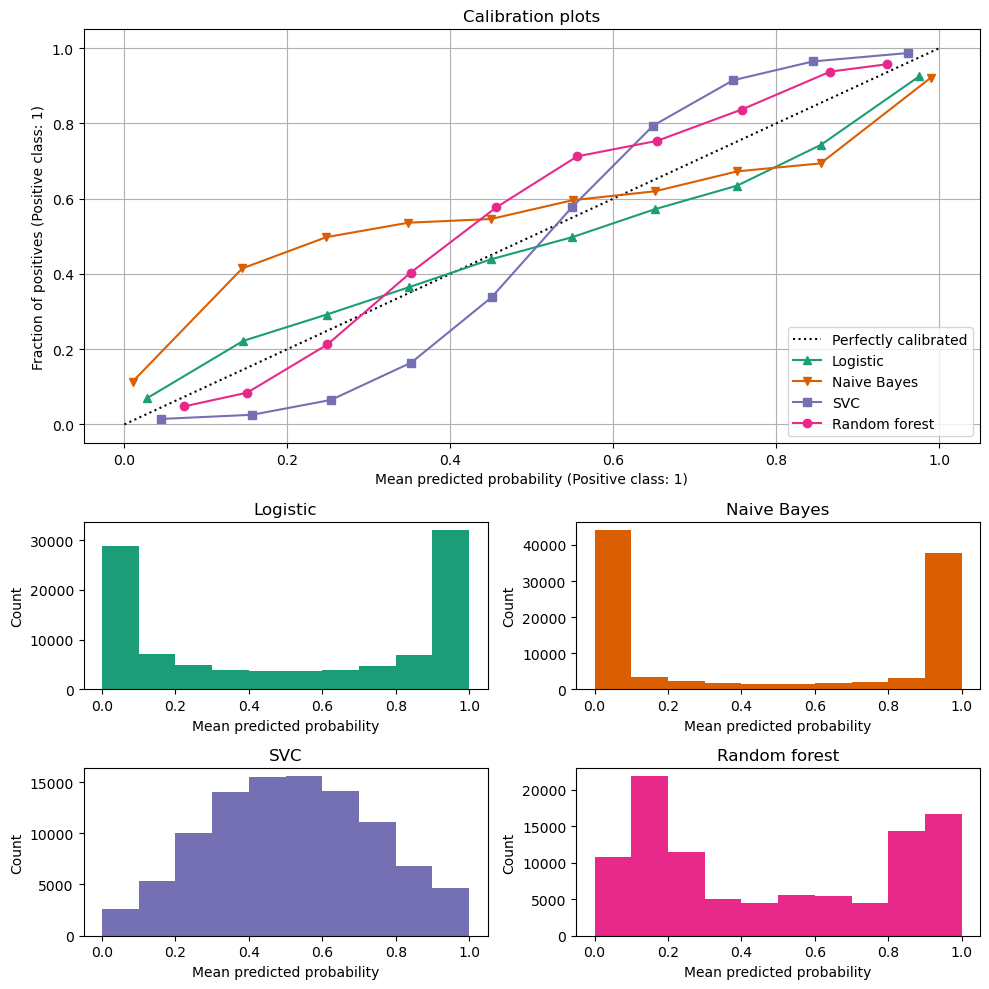

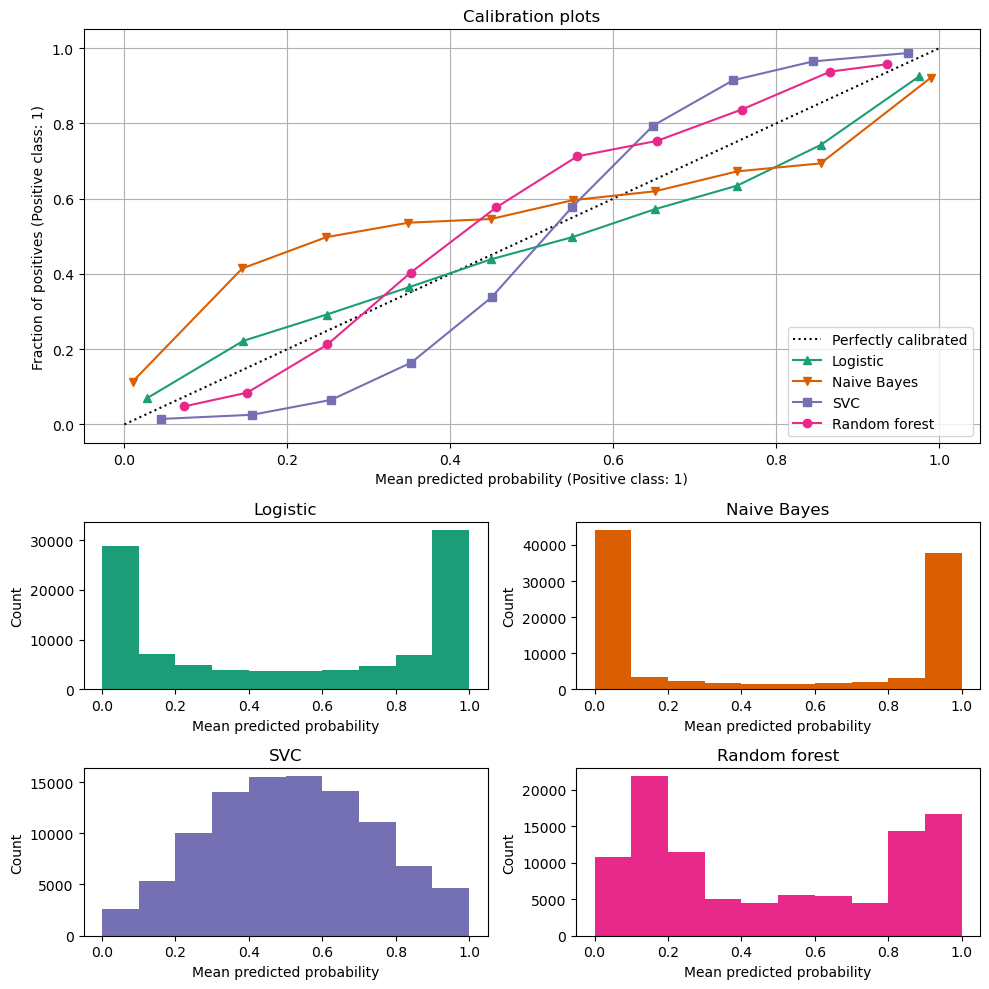

In [15]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o"]
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

:class:`~sklearn.linear_model.LogisticRegression` returns well calibrated
predictions as it directly optimizes log-loss. In contrast, the other methods
return biased probabilities, with different biases for each method:

* :class:`~sklearn.naive_bayes.GaussianNB` tends to push
  probabilities to 0 or 1 (see histogram). This is mainly
  because the naive Bayes equation only provides correct estimate of
  probabilities when the assumption that features are conditionally
  independent holds [2]_. However, features tend to be positively correlated
  and is the case with this dataset, which contains 2 features
  generated as random linear combinations of the informative features. These
  correlated features are effectively being 'counted twice', resulting in
  pushing the predicted probabilities towards 0 and 1 [3]_.

* :class:`~sklearn.ensemble.RandomForestClassifier` shows the opposite
  behavior: the histograms show peaks at approx. 0.2 and 0.9 probability,
  while probabilities close to 0 or 1 are very rare. An explanation for this
  is given by Niculescu-Mizil and Caruana [1]_: "Methods such as bagging and
  random forests that average predictions from a base set of models can have
  difficulty making predictions near 0 and 1 because variance in the
  underlying base models will bias predictions that should be near zero or
  one away from these values. Because predictions are restricted to the
  interval [0,1], errors caused by variance tend to be one- sided near zero
  and one. For example, if a model should predict p = 0 for a case, the only
  way bagging can achieve this is if all bagged trees predict zero. If we add
  noise to the trees that bagging is averaging over, this noise will cause
  some trees to predict values larger than 0 for this case, thus moving the
  average prediction of the bagged ensemble away from 0. We observe this
  effect most strongly with random forests because the base-level trees
  trained with random forests have relatively high variance due to feature
  subsetting." As a result, the calibration curve shows a characteristic
  sigmoid shape, indicating that the classifier is under-confident
  and could return probabilities closer to 0 or 1.

* To show the performance of :class:`~sklearn.svm.LinearSVC`, we naively
  scale the output of the :term:`decision_function` into [0, 1] by applying
  min-max scaling, since SVC does not output probabilities by default.
  :class:`~sklearn.svm.LinearSVC` shows an
  even more sigmoid curve than the
  :class:`~sklearn.ensemble.RandomForestClassifier`, which is typical for
  maximum-margin methods [1]_ as they focus on difficult to classify samples
  that are close to the decision boundary (the support vectors).

## References

.. [1] [Predicting Good Probabilities with Supervised Learning](https://dl.acm.org/doi/pdf/10.1145/1102351.1102430),
       A. Niculescu-Mizil & R. Caruana, ICML 2005
.. [2] [Beyond independence: Conditions for the optimality of the simple
       bayesian classifier](https://www.ics.uci.edu/~pazzani/Publications/mlc96-pedro.pdf)
       Domingos, P., & Pazzani, M., Proc. 13th Intl. Conf. Machine Learning.
       1996.
.. [3] [Obtaining calibrated probability estimates from decision trees and
       naive Bayesian classifiers](https://citeseerx.ist.psu.edu/doc_view/pid/4f67a122ec3723f08ad5cbefecad119b432b3304)
       Zadrozny, Bianca, and Charles Elkan. Icml. Vol. 1. 2001.

